In [246]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [247]:
import seaborn as sns
cpal = sns.color_palette()

import nengolib
from nengolib import Lowpass
from nengo.processes import WhiteSignal

from nengo.utils.numpy import rmse, rms

from nengolib.signal import s

In [248]:
dt = 0.00005
T = 2.0
t = np.arange(0, T, dt)
freqs = np.linspace(5, 50, 10)

def nrmse(output, ideal):
    return rmse(output, ideal) / rms(ideal)

def make_u(freq):
    # WhiteSignal(T, high=freq, y0=0).run(T, dt=dt)
    return np.cos(2*np.pi*freq*t) # * 2 * np.pi * freq

In [249]:
tau1 = 0.031
tau2 = 0.0008
eps  = 0.0004
taup = 0.001

c1 = tau1 + tau2 + (eps/2)
c2 = tau1*tau2 + (eps/2)*(tau1 + tau2) + (eps**2/12)
c3 = (eps/2)*tau1*tau2 + (eps**2/12)*(tau1 + tau2)

den = [taup*c3, taup*c2 + c3, taup*c1 + c2, c1, 0]

# H_common = nengolib.signal.LinearSystem(([c3, c2, c1], den))

H_p3error = nengolib.signal.LinearSystem((
        [-c3, -c2, tau1 - c1],
        den))

H_epserror = nengolib.signal.LinearSystem((
        [-c3, tau1*(eps/2) - c2, tau1 + (eps/2) - c1],
        den))

H_dexperror = nengolib.signal.LinearSystem((
        [-c3, tau1*tau2 - c2, tau1 + tau2 - c1],
        den))

H_fullerror = nengolib.signal.LinearSystem((
        [-c3, tau1*tau2 + (eps/2)*(tau1 + tau2) - c2, tau1 + tau2 + (eps/2) - c1],
        den))

H_ideal = Lowpass(taup) / s

In [250]:
p3_nrmses = np.empty((len(freqs), 1))
eps_nrmses = np.empty_like(p3_nrmses)
dexp_nrmses = np.empty_like(p3_nrmses)
full_nrmses = np.empty_like(p3_nrmses)

for i, freq in enumerate(freqs):
    for j in range(p3_nrmses.shape[1]):
        u = make_u(freq)

        y = H_ideal.filt(u, dt=dt)
        # nrmse(H_p3y.filt(u, dt=dt), ideal=H_ideal.filt(u, dt=dt))
        p3_nrmses[i, j] = rms(H_p3error.filt(u, dt=dt)) / rms(y)
        eps_nrmses[i, j] = rms(H_epserror.filt(u, dt=dt)) / rms(y)
        dexp_nrmses[i, j] = rms(H_dexperror.filt(u, dt=dt)) / rms(y)
        full_nrmses[i, j] = rms(H_fullerror.filt(u, dt=dt)) / rms(y)
        

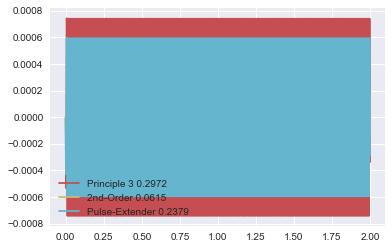

0.000523339694389 0.000522950188989


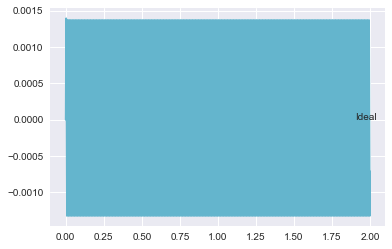

0.000952909437128 0.00095327009255


In [251]:
freq = 100
u = make_u(freq)

p3 = H_p3error.filt(u, dt=dt)

figure()
plot(t, p3, c=cpal[2], label="Principle 3 %.4f" % np.mean(p3_nrmses[-1]))
plot(t, H_dexperror.filt(u, dt=dt), c=cpal[4], label="2nd-Order %.4f" % np.mean(dexp_nrmses[-1]))
plot(t, H_epserror.filt(u, dt=dt), c=cpal[5], label="Pulse-Extender %.4f" % np.mean(eps_nrmses[-1]))
legend()
show()

#print np.sqrt(np.var(p3) + np.mean(p3)**2), rms(p3)
#print abs(H_p3error.evaluate(freq))**2 / 2, np.var(p3)
#print H_p3error.evaluate(freq).imag, np.mean(p3)
#print abs(H_p3error.evaluate(freq)), rms(p3)
#print np.sqrt(abs(H_p3error.evaluate(freq))**2 / 2 + (-abs(H_p3error.evaluate(freq)) / 2)**2), rms(p3)
print abs(H_p3error.evaluate(freq)) / np.sqrt(2), rms(p3)

y = H_ideal.filt(u, dt=dt)

figure()
#plot(t, H_y.filt(u, dt=dt), label="P3")
plot(t, y, c=cpal[5], label="Ideal")
legend()
show()

#print np.sqrt(np.var(y) + np.mean(y)**2), rms(y)
#print np.mean(y), 1./(2*np.pi*freq)
#print np.var(y), abs(H_ideal.evaluate(freq))**2 / 2
#print np.sqrt(abs(H_ideal.evaluate(freq))**2 / 2 + 1./(2*np.pi*freq)**2), rms(y)
print abs(H_ideal.evaluate(freq)) / np.sqrt(2), rms(y)

In [252]:
def h2_bounded(H, upper, lower=1./(2*T), n_samples=1000):
    # lower bound is inversely proportional to total simulation time
    #p = 0
    #for w in :
    #    p += abs(H(2j*np.pi*w))**2 * dw
    w = np.linspace(lower, upper, n_samples)
    dw = w[1] - w[0]
    p = np.sum(abs(H.evaluate(w))**2 * dw)
    return np.sqrt(p / (2*np.pi*(upper - lower)))

In [253]:
powers_analytical = abs(H_ideal.evaluate(freqs))
p3errors_analytical = abs(H_p3error.evaluate(freqs))
epserrors_analytical = abs(H_epserror.evaluate(freqs))
dexperrors_analytical = abs(H_dexperror.evaluate(freqs))
fullerrors_analytical = abs(H_fullerror.evaluate(freqs))
    
#p3errors_analytical = np.sqrt(abs(H_p3error.evaluate(freqs))**2/2 + 1./(2*np.pi*freqs)**2)
#epserrors_analytical = np.sqrt(abs(H_epserror.evaluate(freqs))**2/2 + 1./(2*np.pi*freqs)**2)
#dexperrors_analytical = np.sqrt(abs(H_dexperror.evaluate(freqs))**2/2 + 1./(2*np.pi*freqs)**2)
#powers_analytical = np.sqrt(abs(H_ideal.evaluate(freqs))**2/2 + 1./(2*np.pi*freqs)**2)

#p3errors_analytical += (1./(2*np.pi*freqs))**2
#epserrors_analytical += (1./(2*np.pi*freqs))**2
#dexperrors_analytical += (1./(2*np.pi*freqs))**2

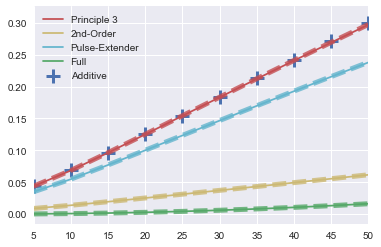

In [254]:
figure()
sns.tsplot(p3_nrmses.T, freqs, err_style='ci_band', color=cpal[2], condition='Principle 3')
plot(freqs, p3errors_analytical / powers_analytical, c=cpal[2], alpha=0.8, linestyle='--', lw=5)

sns.tsplot(dexp_nrmses.T, freqs, err_style='ci_band', color=cpal[4], condition='2nd-Order')
plot(freqs, dexperrors_analytical / powers_analytical, c=cpal[4], alpha=0.8, linestyle='--', lw=5)

sns.tsplot(eps_nrmses.T, freqs, err_style='ci_band', color=cpal[5], condition='Pulse-Extender')
plot(freqs, epserrors_analytical / powers_analytical, c=cpal[5], alpha=0.8, linestyle='--', lw=5)

sns.tsplot(full_nrmses.T, freqs, err_style='ci_band', color=cpal[1], condition='Full')
plot(freqs, fullerrors_analytical / powers_analytical, c=cpal[1], alpha=0.8, linestyle='--', lw=5)

scatter(freqs, (dexperrors_analytical + epserrors_analytical) / powers_analytical,
        marker='+', lw=3, s=200, color=cpal[0], label='Additive')

legend()
show()

In [255]:
#powers = np.empty((len(freqs), 1))
#for i, freq in enumerate(freqs):
#    for j in range(powers.shape[1]):
#        u = make_u(freq)
#        powers[i, j] = rms(H_ideal.filt(u, dt=dt))

#figure()
#sns.tsplot(powers.T, freqs, err_style='ci_band', color=cpal[1], condition='Powers')
#scatter(freqs, powers_analytical, marker='X')
#plot(freqs, abs(H_ideal.evaluate(freqs)))
#legend()
#show()

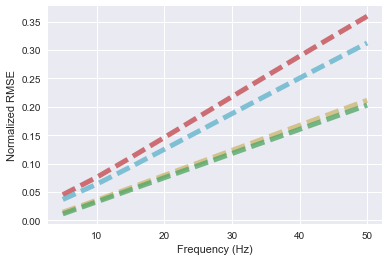

In [290]:
tau1 = 0.031
tau2 = 0.0008
eps  = 0.0004
gam  = 1./eps

#tau2 = 0

def p3(s):
    return tau1

def box_filter(s):
    return tau1*(eps/2)*s + (tau1 + (eps/2))

def double_exp(s):
    return tau1*tau2*s + (tau1 + tau2)

def full(s):
    return (tau1*tau2 + (eps/2)*(tau1 + tau2))*s + (tau1 + tau2 + (eps/2))

def H(s):
    return gam*(1 - np.exp(-eps*s)) / s / ((tau1*s + 1)*(tau2*s + 1))

def b(s):
    return gam*(1 - np.exp(-eps*s)) / s

def d(s):
    return ((tau1*s + 1)*(tau2*s + 1))

def nrmse(f):
    #return np.abs(s*f(s)/(1./H(s) - 1) - 1) #+ 0.019**2*abs(s)
    #return np.abs(f(s)/(1./H(s) - 1) - 1 / s) / np.abs(1 / s)
    #return np.abs(((s*f(s) + 1)*b(s) - d(s)) / (d(s) - b(s)))
    #eta = 0.05**2 * exp(1j*np.pi*0.75)
    return np.sqrt(abs(s*f(s)/(1./H(s) - 1) - 1)**2 + (-0.01 + 0.026**2*abs(s))**2)
    #return abs(s*f(s)/(1./H(s) - (1 + 0.06**2*abs(s))) - 1)
    #return np.sqrt(np.abs(s*f(s)/(1./H(s) - 1) - 1)**2 + np.abs(eta**2*s)**2)
    #return np.abs(s*(eta**2 - H(s)*f(s)) / (H(s) - 1) - 1) 
    #e = s*f(s)/(1./H(s) - 1) - 1
    #return abs(e + (0.01558**2 * abs(s) + 0.0123392496783)*e/abs(e))

s = 2j * np.pi * (freqs)

figure()
#sns.tsplot(p3_nrmses.T, freqs, err_style='ci_band', color=cpal[2], condition='Principle 3')
plot(freqs, nrmse(p3), c=cpal[2], alpha=0.8, linestyle='--', lw=5)

#sns.tsplot(dexp_nrmses.T, freqs, err_style='ci_band', color=cpal[4], condition='2nd-Order')
plot(freqs, nrmse(double_exp), c=cpal[4], alpha=0.8, linestyle='--', lw=5)

#sns.tsplot(eps_nrmses.T, freqs, err_style='ci_band', marker='D', color=cpal[5], condition='Pulse-Extender')
plot(freqs, nrmse(box_filter), c=cpal[5], alpha=0.8, linestyle='--', lw=5)

#sns.tsplot(full_nrmses.T, freqs, err_style='ci_band', marker='X', color=cpal[1], condition='Full')
plot(freqs, nrmse(full), c=cpal[1], alpha=0.8, linestyle='--', lw=5)

#scatter(freqs, nrmse(box_filter) + nrmse(double_exp),
#        marker='+', s=200, color=cpal[0], label='2nd-Order + Pulse-Extender')

xlabel("Frequency (Hz)")
ylabel("Normalized RMSE")

legend()

savefig("integrator_theory.pdf", dpi=300)
show()

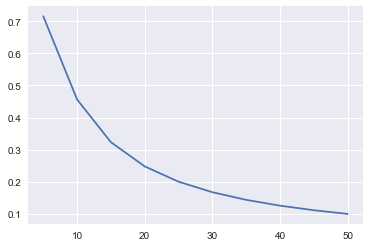

In [257]:
figure()
plot(freqs, np.abs(H(s)))
show()

In [258]:
print 0.0003**0.5

0.0173205080757
